# Classification of Monkey Species using Neural Network

In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import glob
import time
import warnings
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Image Processing

In [2]:
def image_read(folder):
    data = []
    for i in range(0,10,1):
        for filename in glob.glob(folder + "/n{}/*.JPG".format(i)):
            im = Image.open(filename)
            im = im.resize((8, 8))
            pixels = np.asarray(im)
            pixels = pixels.astype('float32')
            pixels /= 255
            data.append((pixels, i))
    return data

In [3]:
data = image_read('training/training/')

In [4]:
labels = {0:"Mantled Howler", 1:"Patas Monkey", 2:"Bald Uakari", 3:"Japanese Macaque",
             4:"Pygmy Marmoset", 5:"White Headed Capuchin", 6:"Silvery Marmoset", 7:"Common Squirrel Monkey",
             8:"Black Headed Night Monkey", 9:"Nilgiri Langur"}

In [5]:
image_list = []
label_list = []
for i in range(0,len(data)):
    img,label = data[i]
    image_list.append(img)
    label_list.append(label)
df = pd.DataFrame( {'Images': image_list, 'Species': label_list})
df.head()

,Images,Species
0,"[[[0.52156866, 0.5176471, 0.3137255], [0.77647...",0
1,"[[[0.48235294, 0.5254902, 0.26666668], [0.2901...",0
2,"[[[0.6784314, 0.75686276, 0.43137255], [0.6509...",0
3,"[[[0.67058825, 0.7882353, 0.5882353], [0.73333...",0
4,"[[[0.60784316, 0.7058824, 0.44705883], [0.6745...",0


In [6]:
df['Species'].value_counts()

3    122
7    114
5    113
1    111
2    110
6    106
8    106
0    105
4    105
9    105
Name: Species, dtype: int64

In [7]:
X = image_list
y = label_list

In [8]:
for i in range(0,len(image_list)):
    image_list[i] = image_list[i].reshape(192,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Multi Layer Neural Network 

In [11]:
def sigmoid(x):
    return 1./(1.+ np.exp(-x))

def softmax(x):
    return np.exp(x)/np.exp(x).sum(axis=1,keepdims=True)

def loss(y_predict,y):
    return ((-np.log(y_predict))*y).sum(axis=1).mean()

In [12]:
class MLP():
    
    def __init__(self,X,Y,X_test,Y_test,L=1,NL=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(10)[Y.astype(np.int).reshape(-1)])
        self.X_test = np.concatenate((X_test,np.ones((X_test.shape[0],1))),axis=1)
        self.Y_test = np.squeeze(np.eye(10)[Y_test.astype(np.int).reshape(-1)])
        self.L = L
        self.NL = NL
        self.n_values = self.X.shape[0]
        layer_r = self.X.shape[1]
        layer_c = self.Y.shape[1]
        self.layer_sizes =np.array([layer_r] + [NL] * L + [layer_c]) 
        self.__init_weights()
        
    
    def __to_categorical(self,X):  
        shapeX = X.shape[0]
        categorical = np.zeros((shapeX,self.Y.shape[1]))
        cat_const = np.arange(shapeX),X.argmax(axis=1)
        categorical[cat_const] = 1
        return categorical
    
    def __init_weights(self):
        self.weights = []
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __forwardProp(self,batch):
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = softmax(self.__h[-1])
    
    def __backProp(self,batch_y):
        h = self.__h
        delta = (self.__out - batch_y)*((h[-1])*(1-h[-1]))
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(h[-i-1].T.dot(delta))/self.batch_size
            delta = ((h[-i-1])* (1-h[-i-1]))*(delta.dot(self.weights[-i].T))
            
    def predict(self,X):
        shape = X.shape[0]
        X = np.concatenate((X,np.ones((shape,1))),axis=1)
        self.__init_layers(shape)
        self.__forwardProp(X)
        return self.__to_categorical(self.__out)
        
    def train(self,batch_size,epochs,lr):
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(0,epochs):
            self.__init_layers(self.batch_size)
            shuffled = np.random.permutation(self.n_values)
            batchX = np.array_split(self.X[shuffled],self.n_values/self.batch_size)
            batchY = np.array_split(self.Y[shuffled],self.n_values/self.batch_size)
            for batch_x,batch_y in zip(batchX,batchY):
                self.__forwardProp(batch_x)  
                self.__backProp(batch_y)
            self.__init_layers(self.X_test.shape[0])
            self.__forwardProp(self.X_test)

In [13]:
def accuracy(y_test , pred):
    counter = 0
    for i in range(0,len(y_test)):
        if y_test[i] == pred[i]:
            counter = counter + 1
    acc = counter / len(pred)
    return acc*100

In [14]:
model1 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128)
model1.train(batch_size=32,epochs=50,lr=0.02)
predict1 = model1.predict(X_test)

In [15]:
predictions1 = []
y_tests1 = []
for i in range(0,len(predict1)):
    for j in range(0,10):
        if predict1[i][j] == 1:
            predictions1.append(j)
for i in range(0,len(y_test)):
    y_tests1.append(y_test[i])
accuracy1 = accuracy(y_tests1,predictions1)
print("Model accuracy is %", "{:.2f}".format(accuracy1))

Model accuracy is % 7.27


In [16]:
model2 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128) #changing the batch size to 128
model2.train(batch_size=128,epochs=50,lr=0.02)
predict2 = model2.predict(X_test)

In [17]:
predictions2 = []
y_tests2 = []
for i in range(0,len(predict2)):
    for j in range(0,10):
        if predict2[i][j] == 1:
            predictions2.append(j)
for i in range(0,len(y_test)):
    y_tests2.append(y_test[i])
accuracy2 = accuracy(y_tests2,predictions2)
print("Model accuracy is %", "{:.2f}".format(accuracy2))

Model accuracy is % 13.64


In [18]:
model3 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128) #changing the epoch to 100
model3.train(batch_size=64,epochs=100,lr=0.02)
predict3 = model3.predict(X_test)

In [19]:
predictions3 = []
y_tests3 = []
for i in range(0,len(predict3)):
    for j in range(0,10):
        if predict3[i][j] == 1:
            predictions3.append(j)
for i in range(0,len(y_test)):
    y_tests3.append(y_test[i])
accuracy3 = accuracy(y_tests3,predictions3)
print("Model accuracy is %", "{:.2f}".format(accuracy3))

Model accuracy is % 21.82


In [20]:
model4 = MLP(X_train,y_train,X_test,y_test,L=3,NL=128) #changing the layer number to 3
model4.train(batch_size=64,epochs=50,lr=0.02)
predict4 = model4.predict(X_test)

In [21]:
predictions4 = []
y_tests4 = []
for i in range(0,len(predict4)):
    for j in range(0,10):
        if predict4[i][j] == 1:
            predictions4.append(j)
for i in range(0,len(y_test)):
    y_tests4.append(y_test[i])
accuracy4 = accuracy(y_tests4,predictions4)
print("Model accuracy is %", "{:.2f}".format(accuracy4))

Model accuracy is % 10.91


In [22]:
model5 = MLP(X_train,y_train,X_test,y_test,L=4,NL=128) #changing the layer number to 4
model5.train(batch_size=64,epochs=50,lr=0.02)
predict5 = model5.predict(X_test)

In [23]:
predictions5 = []
y_tests5 = []
for i in range(0,len(predict5)):
    for j in range(0,10):
        if predict5[i][j] == 1:
            predictions5.append(j)
for i in range(0,len(y_test)):
    y_tests5.append(y_test[i])
accuracy5 = accuracy(y_tests5,predictions5)
print("Model accuracy is %", "{:.2f}".format(accuracy5))

Model accuracy is % 6.36


In [24]:
model6 = MLP(X_train,y_train,X_test,y_test,L=2,NL=256) #changing the layer size to 256
model6.train(batch_size=64,epochs=50,lr=0.02)
predict6 = model6.predict(X_test)

In [25]:
predictions6 = []
y_tests6 = []
for i in range(0,len(predict6)):
    for j in range(0,10):
        if predict6[i][j] == 1:
            predictions6.append(j)
for i in range(0,len(y_test)):
    y_tests6.append(y_test[i])
accuracy6 = accuracy(y_tests6,predictions6)
print("Model accuracy is %", "{:.2f}".format(accuracy6))

Model accuracy is % 5.45


In [26]:
model7 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128) #changing the learning rate to 0.005
model7.train(batch_size=64,epochs=50,lr=0.005)
predict7 = model7.predict(X_test)

In [27]:
predictions7 = []
y_tests7 = []
for i in range(0,len(predict7)):
    for j in range(0,10):
        if predict7[i][j] == 1:
            predictions7.append(j)
for i in range(0,len(y_test)):
    y_tests7.append(y_test[i])
accuracy7 = accuracy(y_tests7,predictions7)
print("Model accuracy is %", "{:.2f}".format(accuracy7))

Model accuracy is % 7.27


In [28]:
model8 = MLP(X_train,y_train,X_test,y_test,L=2,NL=256) #changing the learning rate to 0.005 and layer size to 256
model8.train(batch_size=64,epochs=50,lr=0.005)
predict8 = model8.predict(X_test)

In [29]:
predictions8 = []
y_tests8 = []
for i in range(0,len(predict8)):
    for j in range(0,10):
        if predict8[i][j] == 1:
            predictions8.append(j)
for i in range(0,len(y_test)):
    y_tests8.append(y_test[i])
accuracy8 = accuracy(y_tests8,predictions8)
print("Model accuracy is %", "{:.2f}".format(accuracy8))

Model accuracy is % 7.27


In [30]:
model9 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128) #changing the learning rate to 0.005 and layer size to 256
model9.train(batch_size=64,epochs=50,lr=0.02)
predict9 = model9.predict(X_test)

In [31]:
predictions9 = []
y_tests9 = []
for i in range(0,len(predict9)):
    for j in range(0,10):
        if predict9[i][j] == 1:
            predictions9.append(j)
for i in range(0,len(y_test)):
    y_tests9.append(y_test[i])
accuracy9 = accuracy(y_tests9,predictions9)
print("Model accuracy is %", "{:.2f}".format(accuracy9))

Model accuracy is % 12.73


In [32]:
model10 = MLP(X_train,y_train,X_test,y_test,L=2,NL=128) #changing the learning rate to 0.005 and layer size to 256
model10.train(batch_size=128,epochs=100,lr=0.02)
predict10 = model10.predict(X_test)

In [33]:
predictions10 = []
y_tests10 = []
for i in range(0,len(predict10)):
    for j in range(0,10):
        if predict10[i][j] == 1:
            predictions10.append(j)
for i in range(0,len(y_test)):
    y_tests10.append(y_test[i])
accuracy10 = accuracy(y_tests10,predictions10)
print("Model accuracy is %", "{:.2f}".format(accuracy10))

Model accuracy is % 12.73


In [34]:
list_of_acc = []
list_of_acc.append(accuracy1)
list_of_acc.append(accuracy2)
list_of_acc.append(accuracy3)
list_of_acc.append(accuracy4)
list_of_acc.append(accuracy5)
list_of_acc.append(accuracy6)
list_of_acc.append(accuracy7)
list_of_acc.append(accuracy8)
list_of_acc.append(accuracy9)
list_of_acc.append(accuracy10)

## Results 

In [35]:
print("Batch Size:" + "32   " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy1))
print("Batch Size:" + "128  " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy2))
print("Batch Size:" + "64   " + "Epochs:" + "100  " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy3))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "3  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy4))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "4  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy5))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "256" + " " + "Accuracy:" , "{:.2f}".format(accuracy6))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.005 " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy7))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.005 " + "Number of Layers:" + "2  " + "Layer Size:" + "256" + " " + "Accuracy:" , "{:.2f}".format(accuracy8))
print("Batch Size:" + "64   " + "Epochs:" + "50   " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy9))
print("Batch Size:" + "128  " + "Epochs:" + "100  " + "Learning Rate:" + "0.02  " + "Number of Layers:" + "2  " + "Layer Size:" + "128" + " " + "Accuracy:" , "{:.2f}".format(accuracy10))

Batch Size:32   Epochs:50   Learning Rate:0.02  Number of Layers:2  Layer Size:128 Accuracy: 7.27
Batch Size:128  Epochs:50   Learning Rate:0.02  Number of Layers:2  Layer Size:128 Accuracy: 13.64
Batch Size:64   Epochs:100  Learning Rate:0.02  Number of Layers:2  Layer Size:128 Accuracy: 21.82
Batch Size:64   Epochs:50   Learning Rate:0.02  Number of Layers:3  Layer Size:128 Accuracy: 10.91
Batch Size:64   Epochs:50   Learning Rate:0.02  Number of Layers:4  Layer Size:128 Accuracy: 6.36
Batch Size:64   Epochs:50   Learning Rate:0.02  Number of Layers:2  Layer Size:256 Accuracy: 5.45
Batch Size:64   Epochs:50   Learning Rate:0.005 Number of Layers:2  Layer Size:128 Accuracy: 7.27
Batch Size:64   Epochs:50   Learning Rate:0.005 Number of Layers:2  Layer Size:256 Accuracy: 7.27
Batch Size:64   Epochs:50   Learning Rate:0.02  Number of Layers:2  Layer Size:128 Accuracy: 12.73
Batch Size:128  Epochs:100  Learning Rate:0.02  Number of Layers:2  Layer Size:128 Accuracy: 12.73


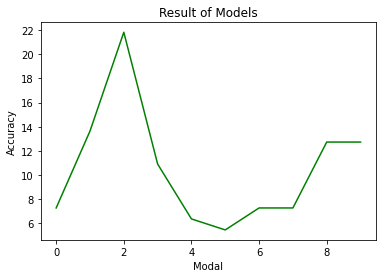

In [36]:
x = range(0,10)
y = list_of_acc

plt.plot(x, y,color='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

### Learning Rate

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. <br> <br>
Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

I tested the "learning rate" parameter in model6 and model8 with keeping other variables the same.

| LR = 0.005 | LR = 0.02 |
| --- | --- |
| 5.45 | 7.27 |

We can say in my modal, bigger learning rate is better.

### Batch Size

Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration. <br>
The smaller the batch the less accurate the estimate of the gradient will be. <br> <br>
I tested the "batch size" parameter in model1, model2 and model9 with keeping other variables the same.

| BS = 32 | BS = 64 | BS = 128 |
| --- | --- | --- |
| 7.27 | 12.73 | 13.64 |

We can say in my modal, bigger batch size is better.

### Epochs

An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset <br>
the machine learning algorithm has completed <br> <br>

I tested the "epochs" parameter in model2 and model10 with keeping other variables the same.

| Epochs = 50 | Epochs = 100 |
| --- | --- |
| 13.64 | 12.73 |

We can say in my modal, 50 epochs is the best. There is a small difference.

### Number of Layers 

I tested the "number of layers" parameter in model4 and model5 with keeping other variables the same.

| 3 Layers | 4 Layers |
| --- | --- |
| 10.91 | 6.91 |

We can say in my modal, less number of layers are better for accuracy.

### Layer Size

I tested the "number of layers" parameter in model7 and model8 with keeping other variables the same.

| LS = 128 | LS = 256 |
| --- | --- |
| 7.27 | 7.27 |

We can say in my modal, layer size didn't changed anything.

# Convolutional Neural Network

In [37]:
image_reshaped = []
for i in range(0,len(image_list)):
    image_reshaped.append(image_list[i].reshape(8,8,3))

In [38]:
X = image_reshaped
y = label_list

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [40]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 1) Single Layer

In [41]:
model1 = Sequential() #Single Layer with learning rate 0.05

model1.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model1.add(MaxPool2D((4, 4)))
model1.add(Flatten())
model1.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model1.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model1.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 7ms/step - loss: 10.9908 - accuracy: 0.0892
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 0s 8ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 0s 8ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 0s 8ms/step - loss: 11.1192 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 0s 8ms/step - loss: 11.1192 - accuracy: 0.0912


In [42]:
test_loss1, test_acc1 = model1.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc1))
print('Test Loss is',"{:.2f}".format(test_loss1))

Test Accuracy is 0.14
Test Loss is 12.38


In [43]:
model2 = Sequential() #Single Layer with learning rate 0.01

model2.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2.add(MaxPool2D((4, 4)))
model2.add(Flatten())
model2.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.01
model2.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 0s 7ms/step - loss: 13.3299 - accuracy: 0.0922
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 0s 8ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 0s 8ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 0s 7ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 0s 8ms/step - loss: 14.6484 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 0s 8ms/step - loss: 14.6484 - accuracy: 0.0912


In [44]:
test_loss2, test_acc2 = model2.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2))
print('Test Loss is',"{:.2f}".format(test_loss2))

Test Accuracy is 0.14
Test Loss is 13.92


In [45]:
model3 = Sequential() #Single Layer with learning rate 0.1

model3.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3.add(MaxPool2D((4, 4)))
model3.add(Flatten())
model3.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.1
model3.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 7ms/step - loss: 10.7558 - accuracy: 0.0973
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 7/10
16/16 [==============================] - 0s 8ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 8/10
16/16 [==============================] - 0s 7ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 9/10
16/16 [==============================] - 0s 7ms/step - loss: 10.9722 - accuracy: 0.1003
Epoch 10/10
16/16 [==============================] - 0s 8ms/step - loss: 10.9722 - accuracy: 0.1003


In [46]:
test_loss3, test_acc3 = model3.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3))
print('Test Loss is',"{:.2f}".format(test_loss3))

Test Accuracy is 0.05
Test Loss is 10.76


In [47]:
from tensorflow.keras.optimizers import SGD
model4 = Sequential() #Single Layer with learning rate 0.001, optimizer = SGD

model4.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model4.add(MaxPool2D((4, 4)))
model4.add(Flatten())
model4.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.05
model4.compile(optimizer=SGD(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model4.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 7ms/step - loss: 13.2661 - accuracy: 0.1023
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 7/10
16/16 [==============================] - 0s 6ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 8/10
16/16 [==============================] - 0s 8ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 9/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003
Epoch 10/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6431 - accuracy: 0.1003


In [48]:
test_loss4, test_acc4 = model4.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc4))
print('Test Loss is',"{:.2f}".format(test_loss4))

Test Accuracy is 0.05
Test Loss is 14.32


In [49]:
from tensorflow.keras.optimizers import Adadelta
model5 = Sequential() #Single Layer with learning rate 0.001, optimizer = Adadelta

model5.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model5.add(MaxPool2D((4, 4)))
model5.add(Flatten())
model5.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.05
model5.compile(optimizer=Adadelta(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model5.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 0s 7ms/step - loss: 7.3329 - accuracy: 0.1003
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 7.0112 - accuracy: 0.0922
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 7.3382 - accuracy: 0.1033
Epoch 4/10
16/16 [==============================] - 0s 8ms/step - loss: 8.0853 - accuracy: 0.0973
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 6.1408 - accuracy: 0.1256
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 2.3520 - accuracy: 0.0922
Epoch 7/10
16/16 [==============================] - 0s 7ms/step - loss: 2.3003 - accuracy: 0.0922
Epoch 8/10
16/16 [==============================] - 0s 8ms/step - loss: 2.3003 - accuracy: 0.0922
Epoch 9/10
16/16 [==============================] - 0s 7ms/step - loss: 2.3003 - accuracy: 0.0922
Epoch 10/10
16/16 [==============================] - 0s 8ms/step - loss: 2.3003 - accuracy: 0.0922


In [50]:
test_loss5, test_acc5 = model5.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc5))
print('Test Loss is',"{:.2f}".format(test_loss5))

Test Accuracy is 0.15
Test Loss is 2.43


In [51]:
from tensorflow.keras.optimizers import Nadam
model6 = Sequential() #Single Layer with learning rate 0.001, optimizer = Nadam

model6.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model6.add(MaxPool2D((4, 4)))
model6.add(Flatten())
model6.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.05
model6.compile(optimizer=Nadam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model6.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 8ms/step - loss: 13.3420 - accuracy: 0.0973
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 7/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 8/10
16/16 [==============================] - 0s 7ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 9/10
16/16 [==============================] - 0s 11ms/step - loss: 13.6595 - accuracy: 0.1044
Epoch 10/10
16/16 [==============================] - 0s 10ms/step - loss: 13.6595 - accuracy: 0.1044


In [52]:
test_loss6, test_acc6 = model6.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc6))
print('Test Loss is',"{:.2f}".format(test_loss6))

Test Accuracy is 0.06
Test Loss is 13.59


In [53]:
model7 = Sequential() #Single Layer with learning rate 0.001,layer size = 128

model7.add(Conv2D(128,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model7.add(MaxPool2D((4, 4)))
model7.add(Flatten())
model7.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.05
model7.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model7.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 0s 5ms/step - loss: 4.2175 - accuracy: 0.0963
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 2.3026 - accuracy: 0.0912


In [54]:
test_loss7, test_acc7 = model7.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc7))
print('Test Loss is',"{:.2f}".format(test_loss7))

Test Accuracy is 0.14
Test Loss is 2.30


In [55]:
model8 = Sequential() #Single Layer with learning rate 0.001,layer size = 64

model8.add(Conv2D(64,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model8.add(MaxPool2D((4, 4)))
model8.add(Flatten())
model8.add(Dense(10 , activation='relu')) #output layer
learning_rate = 0.05
model8.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model8.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 0s 3ms/step - loss: 8.6462 - accuracy: 0.0922
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 8.5689 - accuracy: 0.0912


In [56]:
test_loss8, test_acc8 = model8.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc8))
print('Test Loss is',"{:.2f}".format(test_loss8))

Test Accuracy is 0.14
Test Loss is 6.33


In [57]:
model9 = Sequential() #Single Layer with learning rate 0.001, activation = sigmoid

model9.add(Conv2D(256,(3,3), activation='sigmoid', input_shape=(8, 8, 3))) #input layer
model9.add(MaxPool2D((4, 4)))
model9.add(Flatten())
model9.add(Dense(10 , activation='sigmoid')) #output layer
learning_rate = 0.05
model9.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model9.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 0s 7ms/step - loss: 4.1592 - accuracy: 0.0952
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 2.3558 - accuracy: 0.1287
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 2.2951 - accuracy: 0.1449
Epoch 4/10
16/16 [==============================] - 0s 11ms/step - loss: 2.2680 - accuracy: 0.1651
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 2.2577 - accuracy: 0.1743
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 2.2515 - accuracy: 0.1814
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 2.2269 - accuracy: 0.1854
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 2.1781 - accuracy: 0.1945
Epoch 9/10
16/16 [==============================] - 0s 12ms/step - loss: 2.1255 - accuracy: 0.2178
Epoch 10/10
16/16 [==============================] - 0s 19ms/step - loss: 2.0705 - accuracy: 0.2371


In [58]:
test_loss9, test_acc9 = model9.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc9))
print('Test Loss is',"{:.2f}".format(test_loss9))

Test Accuracy is 0.23
Test Loss is 2.08


In [59]:
model10 = Sequential() #Single Layer with learning rate 0.001, activation = softmax

model10.add(Conv2D(256,(3,3), activation='softmax', input_shape=(8, 8, 3))) #input layer
model10.add(MaxPool2D((4, 4)))
model10.add(Flatten())
model10.add(Dense(10 , activation='softmax')) #output layer
learning_rate = 0.05
model10.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model10.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 16ms/step - loss: 2.3113 - accuracy: 0.1094
Epoch 2/10
16/16 [==============================] - 0s 12ms/step - loss: 2.2416 - accuracy: 0.1884
Epoch 3/10
16/16 [==============================] - 0s 13ms/step - loss: 2.0488 - accuracy: 0.3009
Epoch 4/10
16/16 [==============================] - 0s 19ms/step - loss: 1.8108 - accuracy: 0.3506
Epoch 5/10
16/16 [==============================] - 0s 15ms/step - loss: 1.6663 - accuracy: 0.4195
Epoch 6/10
16/16 [==============================] - 0s 17ms/step - loss: 1.5473 - accuracy: 0.4265
Epoch 7/10
16/16 [==============================] - 0s 14ms/step - loss: 1.4636 - accuracy: 0.4894
Epoch 8/10
16/16 [==============================] - 0s 14ms/step - loss: 1.4305 - accuracy: 0.4833
Epoch 9/10
16/16 [==============================] - 0s 14ms/step - loss: 1.3951 - accuracy: 0.4934
Epoch 10/10
16/16 [==============================] - 0s 13ms/step - loss: 1.3534 - accuracy: 0.5117


In [60]:
test_loss10, test_acc10 = model10.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc10))
print('Test Loss is',"{:.2f}".format(test_loss10))

Test Accuracy is 0.41
Test Loss is 1.60


In [61]:
accuracy_list = []
loss_list = []
accuracy_list.append(test_acc1)
accuracy_list.append(test_acc2)
accuracy_list.append(test_acc3)
accuracy_list.append(test_acc4)
accuracy_list.append(test_acc5)
accuracy_list.append(test_acc6)
accuracy_list.append(test_acc7)
accuracy_list.append(test_acc8)
accuracy_list.append(test_acc9)
accuracy_list.append(test_acc10)
loss_list.append(test_loss1)
loss_list.append(test_loss2)
loss_list.append(test_loss3)
loss_list.append(test_loss4)
loss_list.append(test_loss5)
loss_list.append(test_loss6)
loss_list.append(test_loss7)
loss_list.append(test_loss8)
loss_list.append(test_loss9)
loss_list.append(test_loss10)

## Results 

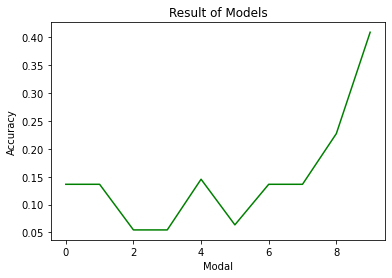

In [62]:
x = range(0,10)
y = accuracy_list

plt.plot(x, y,color='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

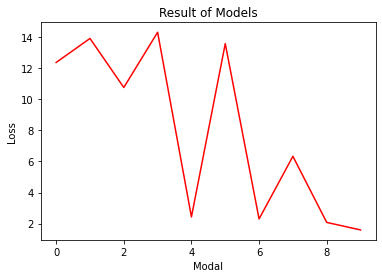

In [63]:
x = range(0,10)
y = loss_list
plt.plot(x, y,color='r')
plt.xlabel('Modal')
plt.ylabel('Loss')
plt.title('Result of Models')
plt.show()

### Activation Function 

| relu | sigmoid | softmax |
| --- | --- | --- |
| 14 | 23 | 41 |

Softmax function is the best for my modal.

### Optimizer

| Adam | SGD | Nadam | Adadelta
| --- | --- | --- | --- |
| 5 | 5 | 6 | 15 |

Best optimizer is Adadelta

### Learning Rate 

| LR = 0.01 | LR = 0.05 | LR = 0.1 |
| --- | --- | --- |
| 14 | 14 | 5 |

Big learning rate is not good for my modal.

##  2) One Hidden Layer

In [64]:
model2_1 = Sequential() #One Hidden Layer with learning rate 0.05

model2_1.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_1.add(MaxPool2D((2, 2)))
model2_1.add(Conv2D(512,(3,3), activation='relu')) #hidden layer
model2_1.add(MaxPool2D((1, 1)))
model2_1.add(Flatten())
model2_1.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model2_1.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_1.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 193ms/step - loss: 12.2758 - accuracy: 0.0932
Epoch 2/10
16/16 [==============================] - 3s 202ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 3/10
16/16 [==============================] - 3s 182ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 4/10
16/16 [==============================] - 3s 176ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 5/10
16/16 [==============================] - 3s 173ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 6/10
16/16 [==============================] - 3s 185ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 7/10
16/16 [==============================] - 3s 186ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 8/10
16/16 [==============================] - 3s 171ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 9/10
16/16 [==============================] - 3s 172ms/step - loss: 12.4809 - accuracy: 0.1003
Epoch 10/10
16/16 [==============================] - 3s 207ms/step - loss: 12.4809 - accura

In [65]:
test_loss2_1, test_acc2_1 = model2_1.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_1))
print('Test Loss is',"{:.2f}".format(test_loss2_1))

Test Accuracy is 0.06
Test Loss is 11.94


In [66]:
model2_2 = Sequential() #One Hidden Layer with learning rate 0.01

model2_2.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_2.add(MaxPool2D((2, 2)))
model2_2.add(Conv2D(512,(3,3), activation='relu')) #hidden layer
model2_2.add(MaxPool2D((1, 1)))
model2_2.add(Flatten())
model2_2.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.01
model2_2.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_2.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 180ms/step - loss: 11.9330 - accuracy: 0.0932
Epoch 2/10
16/16 [==============================] - 3s 188ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 3/10
16/16 [==============================] - 3s 199ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 4/10
16/16 [==============================] - 3s 198ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 5/10
16/16 [==============================] - 3s 180ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 6/10
16/16 [==============================] - 3s 162ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 7/10
16/16 [==============================] - 3s 170ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 8/10
16/16 [==============================] - 3s 204ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 9/10
16/16 [==============================] - 4s 225ms/step - loss: 12.3176 - accuracy: 0.0963
Epoch 10/10
16/16 [==============================] - 3s 188ms/step - loss: 12.3176 - accura

In [67]:
test_loss2_2, test_acc2_2 = model2_2.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_2))
print('Test Loss is',"{:.2f}".format(test_loss2_2))

Test Accuracy is 0.10
Test Loss is 13.55


In [68]:
model2_3 = Sequential() #One Hidden Layer with hidden layer size 128

model2_3.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_3.add(MaxPool2D((2, 2)))
model2_3.add(Conv2D(128,(3,3), activation='relu')) #hidden layer
model2_3.add(MaxPool2D((1, 1)))
model2_3.add(Flatten())
model2_3.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model2_3.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_3.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 43ms/step - loss: 9.5719 - accuracy: 0.0922
Epoch 2/10
16/16 [==============================] - 1s 37ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 1s 38ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 1s 37ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 1s 40ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 1s 36ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 1s 37ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 1s 43ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 1s 47ms/step - loss: 9.8563 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 1s 36ms/step - loss: 9.8563 - accuracy: 0.0912


In [69]:
test_loss2_3, test_acc2_3 = model2_3.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_3))
print('Test Loss is',"{:.2f}".format(test_loss2_3))

Test Accuracy is 0.14
Test Loss is 9.38


In [70]:
model2_4 = Sequential() #One Hidden Layer with hidden layer size 256

model2_4.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_4.add(MaxPool2D((2, 2)))
model2_4.add(Conv2D(256,(3,3), activation='relu')) #hidden layer
model2_4.add(MaxPool2D((1, 1)))
model2_4.add(Flatten())
model2_4.add(Dense(10, activation='relu')) #output layer
model2_4.add(Dense(10, activation='relu'))
learning_rate = 0.05
model2_4.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_4.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 2s 74ms/step - loss: 9.4279 - accuracy: 0.1033
Epoch 2/10
16/16 [==============================] - 1s 68ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 3/10
16/16 [==============================] - 1s 69ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 4/10
16/16 [==============================] - 1s 67ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 5/10
16/16 [==============================] - 1s 75ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 6/10
16/16 [==============================] - 1s 75ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 7/10
16/16 [==============================] - 1s 92ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 8/10
16/16 [==============================] - 1s 80ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 9/10
16/16 [==============================] - 1s 74ms/step - loss: 9.5133 - accuracy: 0.1003
Epoch 10/10
16/16 [==============================] - 1s 67ms/step - loss: 9.5133 - accuracy: 0.1003


In [71]:
test_loss2_4, test_acc2_4 = model2_4.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_4))
print('Test Loss is',"{:.2f}".format(test_loss2_4))

Test Accuracy is 0.05
Test Loss is 9.96


In [72]:
model2_5 = Sequential() #One Hidden Layer with sigmoid activation function

model2_5.add(Conv2D(256,(3,3), activation='sigmoid', input_shape=(8, 8, 3))) #input layer
model2_5.add(MaxPool2D((2, 2)))
model2_5.add(Conv2D(512,(3,3), activation='sigmoid')) #hidden layer
model2_5.add(MaxPool2D((1, 1)))
model2_5.add(Flatten())
model2_5.add(Dense(10, activation='sigmoid')) #output layer
learning_rate = 0.05
model2_5.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_5.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 187ms/step - loss: 15.4911 - accuracy: 0.0780
Epoch 2/10
16/16 [==============================] - 3s 189ms/step - loss: 7.7845 - accuracy: 0.0892
Epoch 3/10
16/16 [==============================] - 4s 219ms/step - loss: 4.3081 - accuracy: 0.0932
Epoch 4/10
16/16 [==============================] - 3s 187ms/step - loss: 2.8754 - accuracy: 0.0993
Epoch 5/10
16/16 [==============================] - 3s 185ms/step - loss: 2.6214 - accuracy: 0.0952
Epoch 6/10
16/16 [==============================] - 3s 176ms/step - loss: 2.7182 - accuracy: 0.0942
Epoch 7/10
16/16 [==============================] - 3s 168ms/step - loss: 2.6933 - accuracy: 0.10641s - loss: 2.5
Epoch 8/10
16/16 [==============================] - 3s 193ms/step - loss: 2.6802 - accuracy: 0.1196
Epoch 9/10
16/16 [==============================] - 3s 190ms/step - loss: 2.9527 - accuracy: 0.0902
Epoch 10/10
16/16 [==============================] - 4s 228ms/step - loss: 2.7803 - a

In [73]:
test_loss2_5, test_acc2_5 = model2_5.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_5))
print('Test Loss is',"{:.2f}".format(test_loss2_5))

Test Accuracy is 0.10
Test Loss is 2.80


In [74]:
model2_6 = Sequential() #One Hidden Layer with softmax activation function

model2_6.add(Conv2D(256,(3,3), activation='softmax', input_shape=(8, 8, 3))) #input layer
model2_6.add(MaxPool2D((2, 2)))
model2_6.add(Conv2D(512,(3,3), activation='softmax')) #hidden layer
model2_6.add(MaxPool2D((1, 1)))
model2_6.add(Flatten())
model2_6.add(Dense(10, activation='softmax')) #output layer
learning_rate = 0.05
model2_6.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_6.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 203ms/step - loss: 2.3164 - accuracy: 0.0983
Epoch 2/10
16/16 [==============================] - 3s 201ms/step - loss: 2.3128 - accuracy: 0.1033
Epoch 3/10
16/16 [==============================] - 3s 195ms/step - loss: 2.3054 - accuracy: 0.1196
Epoch 4/10
16/16 [==============================] - 3s 194ms/step - loss: 2.2568 - accuracy: 0.1651
Epoch 5/10
16/16 [==============================] - 3s 192ms/step - loss: 2.1894 - accuracy: 0.1966
Epoch 6/10
16/16 [==============================] - 3s 206ms/step - loss: 2.0669 - accuracy: 0.2482
Epoch 7/10
16/16 [==============================] - 3s 204ms/step - loss: 1.9333 - accuracy: 0.2989
Epoch 8/10
16/16 [==============================] - 3s 183ms/step - loss: 1.8689 - accuracy: 0.3232
Epoch 9/10
16/16 [==============================] - 3s 197ms/step - loss: 1.8336 - accuracy: 0.3273
Epoch 10/10
16/16 [==============================] - 3s 196ms/step - loss: 1.7154 - accuracy: 0.4022

In [75]:
test_loss2_6, test_acc2_6 = model2_6.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_6))
print('Test Loss is',"{:.2f}".format(test_loss2_6))

Test Accuracy is 0.37
Test Loss is 1.83


In [76]:
model2_7 = Sequential() #One Hidden Layer with mse loss function

model2_7.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_7.add(MaxPool2D((2, 2)))
model2_7.add(Conv2D(512,(3,3), activation='relu')) #hidden layer
model2_7.add(MaxPool2D((1, 1)))
model2_7.add(Flatten())
model2_7.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model2_7.compile(optimizer=Adam(learning_rate),
              loss='mse',
              metrics=['accuracy'])
fit = model2_7.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 205ms/step - loss: 7676.1455 - accuracy: 0.1023
Epoch 2/10
16/16 [==============================] - 3s 221ms/step - loss: 26.2236 - accuracy: 0.1044
Epoch 3/10
16/16 [==============================] - 3s 181ms/step - loss: 26.1928 - accuracy: 0.1044
Epoch 4/10
16/16 [==============================] - 3s 170ms/step - loss: 26.1548 - accuracy: 0.1044
Epoch 5/10
16/16 [==============================] - 3s 161ms/step - loss: 26.1511 - accuracy: 0.1044
Epoch 6/10
16/16 [==============================] - 3s 169ms/step - loss: 26.1455 - accuracy: 0.1044
Epoch 7/10
16/16 [==============================] - 3s 167ms/step - loss: 26.1309 - accuracy: 0.1044
Epoch 8/10
16/16 [==============================] - 3s 174ms/step - loss: 26.1339 - accuracy: 0.1044
Epoch 9/10
16/16 [==============================] - 3s 195ms/step - loss: 26.1345 - accuracy: 0.1044
Epoch 10/10
16/16 [==============================] - 3s 193ms/step - loss: 26.1455 - accu

In [77]:
test_loss2_7, test_acc2_7 = model2_7.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_7))
print('Test Loss is',"{:.2f}".format(test_loss2_7))

Test Accuracy is 0.06
Test Loss is 25.74


In [78]:
model2_8 = Sequential() #One Hidden Layer with SGD optimizer

model2_8.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model2_8.add(MaxPool2D((2, 2)))
model2_8.add(Conv2D(512,(3,3), activation='relu')) #hidden layer
model2_8.add(MaxPool2D((1, 1)))
model2_8.add(Flatten())
model2_8.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model2_8.compile(optimizer=SGD(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model2_8.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 191ms/step - loss: 7.4881 - accuracy: 0.0963
Epoch 2/10
16/16 [==============================] - 3s 180ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 3/10
16/16 [==============================] - 3s 185ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 4/10
16/16 [==============================] - 3s 213ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 5/10
16/16 [==============================] - 3s 179ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 6/10
16/16 [==============================] - 3s 197ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 7/10
16/16 [==============================] - 3s 191ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 8/10
16/16 [==============================] - 3s 198ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 9/10
16/16 [==============================] - 3s 202ms/step - loss: 7.9810 - accuracy: 0.1044
Epoch 10/10
16/16 [==============================] - 3s 188ms/step - loss: 7.9810 - accuracy: 0.1044

In [79]:
test_loss2_8, test_acc2_8 = model2_8.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc2_8))
print('Test Loss is',"{:.2f}".format(test_loss2_8))

Test Accuracy is 0.06
Test Loss is 10.14


In [80]:
accuracy_list2 = []
loss_list2 = []
accuracy_list2.append(test_acc2_1)
accuracy_list2.append(test_acc2_2)
accuracy_list2.append(test_acc2_3)
accuracy_list2.append(test_acc2_4)
accuracy_list2.append(test_acc2_5)
accuracy_list2.append(test_acc2_6)
accuracy_list2.append(test_acc2_7)
accuracy_list2.append(test_acc2_8)
loss_list2.append(test_loss2_1)
loss_list2.append(test_loss2_2)
loss_list2.append(test_loss2_3)
loss_list2.append(test_loss2_4)
loss_list2.append(test_loss2_5)
loss_list2.append(test_loss2_6)
loss_list2.append(test_loss2_7)
loss_list2.append(test_loss2_8)

## Results

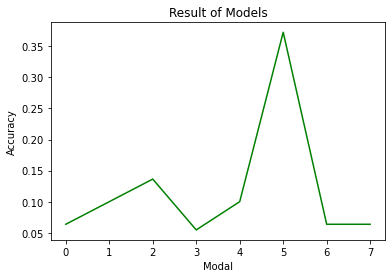

In [81]:
x = range(0,8)
y = accuracy_list2

plt.plot(x, y, color ='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

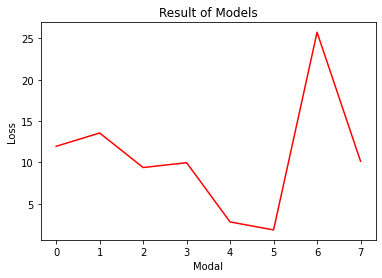

In [82]:
x = range(0,8)
y = loss_list2
plt.plot(x, y,color = 'r')
plt.xlabel('Modal')
plt.ylabel('Loss')
plt.title('Result of Models')
plt.show()

### Layer Size

| LS = 128 | LS = 256 | 
| --- | --- |
| 6 | 14 |

Big layer size is better for my modal

### Objective Function

| Sparse Categorical | MSE | 
| --- | --- |
| 6 | 6 |

Objective function didn't effect to my modal

##  3) Two Hidden Layers 

In [83]:
model3_1 = Sequential() #Two Hidden Layers with learning rate 0.05

model3_1.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_1.add(MaxPool2D((2, 2)))
model3_1.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_1.add(MaxPool2D((1, 1)))
model3_1.add(Flatten())
model3_1.add(Dense(64,activation ='relu')) #second hidden layer
model3_1.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model3_1.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_1.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 5s 252ms/step - loss: 2.7752 - accuracy: 0.0892
Epoch 2/10
16/16 [==============================] - 3s 201ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 3s 172ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 3s 182ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 3s 175ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 3s 171ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 3s 180ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 3s 185ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 3s 176ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 3s 196ms/step - loss: 2.3026 - accuracy: 0.0912

In [84]:
test_loss3_1, test_acc3_1 = model3_1.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_1))
print('Test Loss is',"{:.2f}".format(test_loss3_1))

Test Accuracy is 0.14
Test Loss is 2.30


In [85]:
model3_2 = Sequential() #Two Hidden Layers with learning rate 0.01

model3_2.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_2.add(MaxPool2D((2, 2)))
model3_2.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_2.add(MaxPool2D((1, 1)))
model3_2.add(Flatten())
model3_2.add(Dense(64,activation ='relu')) #second hidden layer
model3_2.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.01
model3_2.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_2.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 197ms/step - loss: 4.3370 - accuracy: 0.0851
Epoch 2/10
16/16 [==============================] - 3s 186ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 3s 183ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 3s 196ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 3s 179ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 3s 186ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 3s 189ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 3s 203ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 3s 181ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 3s 200ms/step - loss: 2.3026 - accuracy: 0.0912

In [86]:
test_loss3_2, test_acc3_2 = model3_2.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_2))
print('Test Loss is',"{:.2f}".format(test_loss3_2))

Test Accuracy is 0.14
Test Loss is 2.30


In [87]:
model3_3 = Sequential() #Two Hidden Layers with input layer size 128

model3_3.add(Conv2D(128,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_3.add(MaxPool2D((2, 2)))
model3_3.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_3.add(MaxPool2D((1, 1)))
model3_3.add(Flatten())
model3_3.add(Dense(64,activation ='relu')) #second hidden layer
model3_3.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model3_3.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_3.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 2s 91ms/step - loss: 10.4560 - accuracy: 0.1013
Epoch 2/10
16/16 [==============================] - 1s 77ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 1s 80ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 1s 83ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 1s 78ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 1s 76ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 1s 77ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 2s 98ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 1s 82ms/step - loss: 11.2662 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 1s 78ms/step - loss: 11.2662 - accuracy: 0.0912

In [88]:
test_loss3_3, test_acc3_3 = model3_3.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_3))
print('Test Loss is',"{:.2f}".format(test_loss3_3))

Test Accuracy is 0.14
Test Loss is 11.79


In [89]:
model3_4 = Sequential() #Two Hidden Layers with loss = mse

model3_4.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_4.add(MaxPool2D((2, 2)))
model3_4.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_4.add(MaxPool2D((1, 1)))
model3_4.add(Flatten())
model3_4.add(Dense(64,activation ='relu')) #second hidden layer
model3_4.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model3_4.compile(optimizer=Adam(learning_rate),
              loss='mse',
              metrics=['accuracy'])
fit = model3_4.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 186ms/step - loss: 25860.7363 - accuracy: 0.0912
Epoch 2/10
16/16 [==============================] - 3s 188ms/step - loss: 14.9914 - accuracy: 0.1013
Epoch 3/10
16/16 [==============================] - 3s 177ms/step - loss: 15.0857 - accuracy: 0.1064
Epoch 4/10
16/16 [==============================] - 3s 192ms/step - loss: 14.1647 - accuracy: 0.1013
Epoch 5/10
16/16 [==============================] - 3s 178ms/step - loss: 9.3385 - accuracy: 0.0902
Epoch 6/10
16/16 [==============================] - 3s 186ms/step - loss: 8.2383 - accuracy: 0.1165
Epoch 7/10
16/16 [==============================] - 3s 206ms/step - loss: 8.0054 - accuracy: 0.0790
Epoch 8/10
16/16 [==============================] - 3s 175ms/step - loss: 8.0509 - accuracy: 0.1216
Epoch 9/10
16/16 [==============================] - 3s 171ms/step - loss: 8.0859 - accuracy: 0.0892
Epoch 10/10
16/16 [==============================] - 3s 168ms/step - loss: 8.0416 - accuracy:

In [90]:
test_loss3_4, test_acc3_4 = model3_4.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_4))
print('Test Loss is',"{:.2f}".format(test_loss3_4))

Test Accuracy is 0.06
Test Loss is 9.96


In [91]:
model3_5 = Sequential() #Two Hidden Layers with optimizer SGD

model3_5.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_5.add(MaxPool2D((2, 2)))
model3_5.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_5.add(MaxPool2D((1, 1)))
model3_5.add(Flatten())
model3_5.add(Dense(64,activation ='relu')) #second hidden layer
model3_5.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model3_5.compile(optimizer=SGD(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_5.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 176ms/step - loss: 12.8972 - accuracy: 0.0871
Epoch 2/10
16/16 [==============================] - 3s 175ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 3/10
16/16 [==============================] - 3s 171ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 4/10
16/16 [==============================] - 3s 178ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 5/10
16/16 [==============================] - 3s 174ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 3s 182ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 7/10
16/16 [==============================] - 3s 202ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 8/10
16/16 [==============================] - 3s 185ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 3s 184ms/step - loss: 13.7248 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 3s 170ms/step - loss: 13.7248 - accura

In [92]:
test_loss3_5, test_acc3_5 = model3_5.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_5))
print('Test Loss is',"{:.2f}".format(test_loss3_5))

Test Accuracy is 0.14
Test Loss is 13.59


In [93]:
model3_6 = Sequential() #Two Hidden Layers with sigmoid function

model3_6.add(Conv2D(256,(3,3), activation='sigmoid', input_shape=(8, 8, 3))) #input layer
model3_6.add(MaxPool2D((2, 2)))
model3_6.add(Conv2D(512,(3,3), activation='sigmoid')) #first hidden layer
model3_6.add(MaxPool2D((1, 1)))
model3_6.add(Flatten())
model3_6.add(Dense(64,activation ='sigmoid')) #second hidden layer
model3_6.add(Dense(10, activation='sigmoid')) #output layer
learning_rate = 0.05
model3_6.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_6.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 180ms/step - loss: 2.7673 - accuracy: 0.1114
Epoch 2/10
16/16 [==============================] - 3s 182ms/step - loss: 2.4289 - accuracy: 0.0871
Epoch 3/10
16/16 [==============================] - 3s 181ms/step - loss: 2.4072 - accuracy: 0.0932
Epoch 4/10
16/16 [==============================] - 3s 174ms/step - loss: 2.4088 - accuracy: 0.1013
Epoch 5/10
16/16 [==============================] - 3s 175ms/step - loss: 2.4162 - accuracy: 0.1023
Epoch 6/10
16/16 [==============================] - 3s 185ms/step - loss: 2.4270 - accuracy: 0.0861
Epoch 7/10
16/16 [==============================] - 3s 172ms/step - loss: 2.3865 - accuracy: 0.0851
Epoch 8/10
16/16 [==============================] - 3s 174ms/step - loss: 2.3950 - accuracy: 0.1013
Epoch 9/10
16/16 [==============================] - 3s 167ms/step - loss: 2.3990 - accuracy: 0.1094
Epoch 10/10
16/16 [==============================] - 3s 191ms/step - loss: 2.4070 - accuracy: 0.0892

In [94]:
test_loss3_6, test_acc3_6 = model3_6.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_6))
print('Test Loss is',"{:.2f}".format(test_loss3_6))

Test Accuracy is 0.10
Test Loss is 2.45


In [95]:
model3_7 = Sequential() #Two Hidden Layers with second hidden layer size 128

model3_7.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #input layer
model3_7.add(MaxPool2D((2, 2)))
model3_7.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model3_7.add(MaxPool2D((1, 1)))
model3_7.add(Flatten())
model3_7.add(Dense(128,activation ='relu')) #second hidden layer
model3_7.add(Dense(10, activation='relu')) #output layer
learning_rate = 0.05
model3_7.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model3_7.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 206ms/step - loss: 13.7356 - accuracy: 0.0902
Epoch 2/10
16/16 [==============================] - 3s 214ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 3/10
16/16 [==============================] - 3s 187ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 4/10
16/16 [==============================] - 3s 185ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 5/10
16/16 [==============================] - 3s 188ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 6/10
16/16 [==============================] - 3s 198ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 7/10
16/16 [==============================] - 3s 190ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 8/10
16/16 [==============================] - 3s 182ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 9/10
16/16 [==============================] - 3s 182ms/step - loss: 14.5830 - accuracy: 0.0952
Epoch 10/10
16/16 [==============================] - 3s 168ms/step - loss: 14.5830 - accura

In [96]:
test_loss3_7, test_acc3_7 = model3_7.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc3_7))
print('Test Loss is',"{:.2f}".format(test_loss3_7))

Test Accuracy is 0.10
Test Loss is 14.51


In [97]:
accuracy_list3 = []
loss_list3 = []
accuracy_list3.append(test_acc3_1)
accuracy_list3.append(test_acc3_2)
accuracy_list3.append(test_acc3_3)
accuracy_list3.append(test_acc3_4)
accuracy_list3.append(test_acc3_5)
accuracy_list3.append(test_acc3_6)
accuracy_list3.append(test_acc3_7)
loss_list3.append(test_loss3_1)
loss_list3.append(test_loss3_2)
loss_list3.append(test_loss3_3)
loss_list3.append(test_loss3_4)
loss_list3.append(test_loss3_5)
loss_list3.append(test_loss3_6)
loss_list3.append(test_loss3_7)

## Results

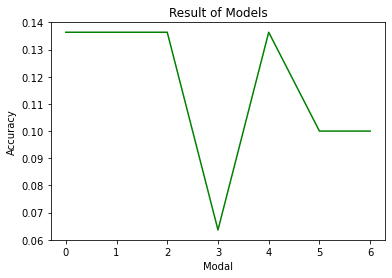

In [98]:
x = range(0,7)
y = accuracy_list3

plt.plot(x, y,color='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

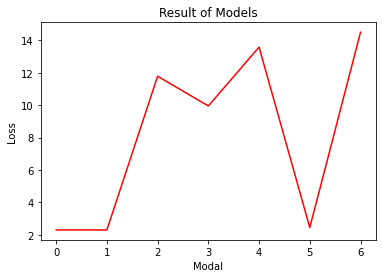

In [99]:
x = range(0,7)
y = loss_list3

plt.plot(x, y,color='r')
plt.xlabel('Modal')
plt.ylabel('Loss')
plt.title('Result of Models')
plt.show()

## 4) One Convolutional Layer and One Fully Connected Layer

In [100]:
model4_1 = Sequential() #one conv layer and one fully layer with 1 hidden layer

model4_1.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #convolutional layer
model4_1.add(MaxPool2D((2, 2)))
model4_1.add(Conv2D(512,(3,3), activation='relu')) #one hidden layer
model4_1.add(MaxPool2D((1, 1)))
model4_1.add(Flatten())
model4_1.add(Dense(10, activation='relu')) #fully connected layer
model4_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model4_1.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 169ms/step - loss: 12.8625 - accuracy: 0.0993
Epoch 2/10
16/16 [==============================] - 3s 180ms/step - loss: 13.3019 - accuracy: 0.0963
Epoch 3/10
16/16 [==============================] - 3s 177ms/step - loss: 13.2786 - accuracy: 0.0963
Epoch 4/10
16/16 [==============================] - 3s 207ms/step - loss: 13.2995 - accuracy: 0.0963
Epoch 5/10
16/16 [==============================] - 3s 206ms/step - loss: 13.2673 - accuracy: 0.0963
Epoch 6/10
16/16 [==============================] - 3s 183ms/step - loss: 13.2852 - accuracy: 0.0963
Epoch 7/10
16/16 [==============================] - 3s 196ms/step - loss: 13.2623 - accuracy: 0.0963
Epoch 8/10
16/16 [==============================] - 3s 190ms/step - loss: 13.2827 - accuracy: 0.0963
Epoch 9/10
16/16 [==============================] - 4s 226ms/step - loss: 13.2737 - accuracy: 0.0963
Epoch 10/10
16/16 [==============================] - 3s 198ms/step - loss: 13.5321 - accura

In [101]:
test_loss4_1, test_acc4_1 = model4_1.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc4_1))
print('Test Loss is',"{:.2f}".format(test_loss4_1))

Test Accuracy is 0.10
Test Loss is 13.42


In [102]:
model4_2 = Sequential() #one conv layer and one fully layer with 2 hidden layer
model4_2.add(Conv2D(256,(3,3), activation='relu', input_shape=(8, 8, 3))) #convolutional layer
model4_2.add(MaxPool2D((2, 2)))
model4_2.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model4_2.add(MaxPool2D((1, 1)))
model4_2.add(Dense(64, activation='relu')) # second hidden layer
model4_2.add(Dense(10, activation='relu')) #fully connected layer
model4_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model4_2.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 191ms/step - loss: 9.4563 - accuracy: 0.0939
Epoch 2/10
16/16 [==============================] - 3s 215ms/step - loss: 8.9671 - accuracy: 0.0938
Epoch 3/10
16/16 [==============================] - 3s 197ms/step - loss: 6.5638 - accuracy: 0.1003
Epoch 4/10
16/16 [==============================] - 4s 227ms/step - loss: 6.0792 - accuracy: 0.1001
Epoch 5/10
16/16 [==============================] - 3s 205ms/step - loss: 2.3380 - accuracy: 0.0898
Epoch 6/10
16/16 [==============================] - 3s 193ms/step - loss: 2.3026 - accuracy: 0.0909
Epoch 7/10
16/16 [==============================] - 3s 181ms/step - loss: 2.3089 - accuracy: 0.0913
Epoch 8/10
16/16 [==============================] - 3s 192ms/step - loss: 2.3026 - accuracy: 0.0909
Epoch 9/10
16/16 [==============================] - 3s 191ms/step - loss: 2.3097 - accuracy: 0.0903
Epoch 10/10
16/16 [==============================] - 3s 182ms/step - loss: 2.3026 - accuracy: 0.0909

In [103]:
test_loss4_2, test_acc4_2 = model4_2.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc4_2))
print('Test Loss is',"{:.2f}".format(test_loss4_2))

Test Accuracy is 0.14
Test Loss is 2.30


In [104]:
model4_3 = Sequential() #one conv layer and one fully layer with 3 hidden layer
model4_3.add(Conv2D(256, 3, activation='relu', input_shape=(8, 8, 3))) #convolutional layer
model4_3.add(MaxPool2D((2, 2)))
model4_3.add(Conv2D(512,(3,3), activation='relu')) #first hidden layer
model4_3.add(MaxPool2D((1, 1)))
model4_3.add(BatchNormalization()) #second hidden layer
model4_3.add(Flatten()) 
model4_3.add(Dense(64,activation='relu')) #third hidden layer
model4_3.add(Dense(10,activation='relu')) #fully connected layer
model4_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model4_3.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 4s 224ms/step - loss: 6.9088 - accuracy: 0.1651
Epoch 2/10
16/16 [==============================] - 3s 180ms/step - loss: 5.6724 - accuracy: 0.1611
Epoch 3/10
16/16 [==============================] - 3s 206ms/step - loss: 5.0623 - accuracy: 0.1631
Epoch 4/10
16/16 [==============================] - 3s 208ms/step - loss: 4.5658 - accuracy: 0.1925
Epoch 5/10
16/16 [==============================] - 3s 191ms/step - loss: 4.3717 - accuracy: 0.2199
Epoch 6/10
16/16 [==============================] - 3s 184ms/step - loss: 4.2104 - accuracy: 0.2573
Epoch 7/10
16/16 [==============================] - 3s 182ms/step - loss: 3.8669 - accuracy: 0.2979
Epoch 8/10
16/16 [==============================] - 3s 201ms/step - loss: 3.6038 - accuracy: 0.2938
Epoch 9/10
16/16 [==============================] - 3s 202ms/step - loss: 3.2643 - accuracy: 0.2685
Epoch 10/10
16/16 [==============================] - 3s 176ms/step - loss: 3.0002 - accuracy: 0.3090

In [105]:
test_loss4_3, test_acc4_3 = model4_3.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc4_3))
print('Test Loss is',"{:.2f}".format(test_loss4_3))

Test Accuracy is 0.28
Test Loss is 3.53


In [106]:
accuracy_list4 = []
loss_list4 = []
accuracy_list4.append(test_acc4_1)
accuracy_list4.append(test_acc4_2)
accuracy_list4.append(test_acc4_3)
loss_list4.append(test_loss4_1)
loss_list4.append(test_loss4_2)
loss_list4.append(test_loss4_3)

## Results

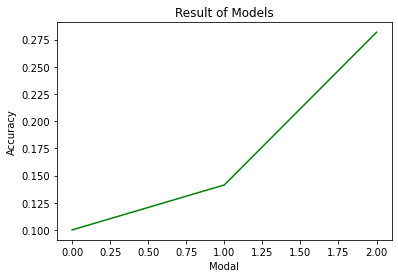

In [107]:
x = range(0,3)
y = accuracy_list4

plt.plot(x, y,color='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

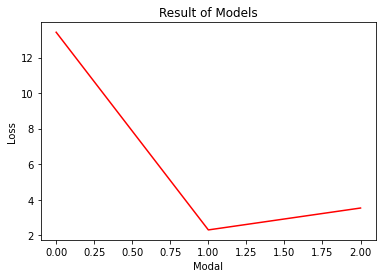

In [108]:
x = range(0,3)
y = loss_list4

plt.plot(x, y,color='r')
plt.xlabel('Modal')
plt.ylabel('Loss')
plt.title('Result of Models')
plt.show()

### Number of Hidden Layers

| 1 HL | 2 HL | 3 HL | 
| --- | --- | --- |
| 10 | 14 | 28 |

More hidden layer, get more accuracy.

## 5) Two Convolutional Layer and Two Fully Connected Layer 

In [109]:
model5_1 = Sequential() #two conv layer and two fully layer
model5_1.add(Conv2D(256, 3, activation='relu', input_shape=(8, 8, 3))) #first convolutional
model5_1.add(MaxPool2D((2, 2))) 
model5_1.add(Conv2D(512, 3, activation='relu')) #second convolutional
model5_1.add(MaxPool2D((1, 1)))
model5_1.add(Flatten()) 
model5_1.add(Dense(64,activation='relu')) #first fully connected
model5_1.add(Dense(10,activation='relu')) #second fully connected
model5_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model5_1.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 3s 188ms/step - loss: 10.2399 - accuracy: 0.1023
Epoch 2/10
16/16 [==============================] - 3s 198ms/step - loss: 9.0456 - accuracy: 0.1196
Epoch 3/10
16/16 [==============================] - 3s 191ms/step - loss: 7.2242 - accuracy: 0.1266
Epoch 4/10
16/16 [==============================] - 3s 207ms/step - loss: 7.2122 - accuracy: 0.1358
Epoch 5/10
16/16 [==============================] - 3s 185ms/step - loss: 7.1120 - accuracy: 0.1327
Epoch 6/10
16/16 [==============================] - 3s 187ms/step - loss: 7.7616 - accuracy: 0.1834
Epoch 7/10
16/16 [==============================] - 3s 187ms/step - loss: 6.6354 - accuracy: 0.0932
Epoch 8/10
16/16 [==============================] - 4s 218ms/step - loss: 2.3183 - accuracy: 0.0912
Epoch 9/10
16/16 [==============================] - 3s 186ms/step - loss: 2.3026 - accuracy: 0.0912
Epoch 10/10
16/16 [==============================] - 3s 177ms/step - loss: 2.3026 - accuracy: 0.091

In [110]:
test_loss5_1, test_acc5_1 = model5_1.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc5_1))
print('Test Loss is',"{:.2f}".format(test_loss5_1))

Test Accuracy is 0.14
Test Loss is 2.30


In [111]:
model5_2 = Sequential() #conv layer sizes changed
model5_2.add(Conv2D(128, 3, activation='relu', input_shape=(8, 8, 3))) #first convolutional
model5_2.add(MaxPool2D((2, 2))) 
model5_2.add(Conv2D(256, 3, activation='relu')) #second convolutional
model5_2.add(MaxPool2D((1, 1)))
model5_2.add(Flatten()) 
model5_2.add(Dense(64,activation='relu')) #first fully connected
model5_2.add(Dense(10,activation='relu')) #second fully connected
model5_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model5_2.fit(X_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 1s 36ms/step - loss: 5.2523 - accuracy: 0.1013
Epoch 2/10
16/16 [==============================] - 1s 36ms/step - loss: 4.5215 - accuracy: 0.1003
Epoch 3/10
16/16 [==============================] - 1s 39ms/step - loss: 3.7093 - accuracy: 0.1044
Epoch 4/10
16/16 [==============================] - 1s 39ms/step - loss: 3.5941 - accuracy: 0.1439
Epoch 5/10
16/16 [==============================] - 1s 44ms/step - loss: 3.4732 - accuracy: 0.1662
Epoch 6/10
16/16 [==============================] - 1s 51ms/step - loss: 3.5161 - accuracy: 0.3222
Epoch 7/10
16/16 [==============================] - 1s 58ms/step - loss: 3.6727 - accuracy: 0.1591
Epoch 8/10
16/16 [==============================] - 1s 44ms/step - loss: 3.6737 - accuracy: 0.0952
Epoch 9/10
16/16 [==============================] - 1s 36ms/step - loss: 3.5529 - accuracy: 0.1429
Epoch 10/10
16/16 [==============================] - 1s 36ms/step - loss: 2.5188 - accuracy: 0.2199


In [112]:
test_loss5_2, test_acc5_2 = model5_2.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc5_2))
print('Test Loss is',"{:.2f}".format(test_loss5_2))

Test Accuracy is 0.15
Test Loss is 2.33


In [113]:
model5_3 = Sequential() #fully layer sizes changed
model5_3.add(Conv2D(128, 3, activation='relu', input_shape=(8, 8, 3))) #first convolutional
model5_3.add(MaxPool2D((2, 2))) 
model5_3.add(Conv2D(256, 3, activation='relu')) #second convolutional
model5_3.add(MaxPool2D((1, 1)))
model5_3.add(Flatten()) 
model5_3.add(Dense(128,activation='relu')) #first fully connected
model5_3.add(Dense(10,activation='relu')) #second fully connected
model5_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit = model5_3.fit(X_train, y_train, epochs=10, batch_size = 128)

Epoch 1/10
8/8 [==============================] - 1s 78ms/step - loss: 5.5627 - accuracy: 0.0932
Epoch 2/10
8/8 [==============================] - 1s 73ms/step - loss: 2.4814 - accuracy: 0.1206
Epoch 3/10
8/8 [==============================] - 1s 80ms/step - loss: 2.3056 - accuracy: 0.1135
Epoch 4/10
8/8 [==============================] - 1s 76ms/step - loss: 2.2941 - accuracy: 0.1388
Epoch 5/10
8/8 [==============================] - 1s 71ms/step - loss: 2.2858 - accuracy: 0.1226
Epoch 6/10
8/8 [==============================] - 1s 83ms/step - loss: 2.2768 - accuracy: 0.1520
Epoch 7/10
8/8 [==============================] - 1s 74ms/step - loss: 2.2629 - accuracy: 0.1611
Epoch 8/10
8/8 [==============================] - 1s 78ms/step - loss: 2.2436 - accuracy: 0.1337
Epoch 9/10
8/8 [==============================] - 1s 75ms/step - loss: 2.2037 - accuracy: 0.1114
Epoch 10/10
8/8 [==============================] - 1s 73ms/step - loss: 2.1354 - accuracy: 0.1530


In [114]:
test_loss5_3, test_acc5_3 = model5_3.evaluate(X_test,
                                     y_test,
                                     verbose=10)
print('Test Accuracy is', "{:.2f}".format(test_acc5_3))
print('Test Loss is',"{:.2f}".format(test_loss5_3))

Test Accuracy is 0.27
Test Loss is 2.33


In [115]:
accuracy_list5 = []
loss_list5 = []
accuracy_list5.append(test_acc5_1)
accuracy_list5.append(test_acc5_2)
accuracy_list5.append(test_acc5_3)
loss_list5.append(test_loss5_1)
loss_list5.append(test_loss5_2)
loss_list5.append(test_loss5_3)

## Results

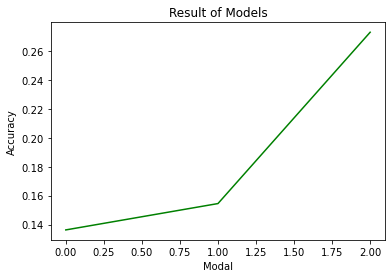

In [116]:
x = range(0,3)
y = accuracy_list5

plt.plot(x, y,color='g')
plt.xlabel('Modal')
plt.ylabel('Accuracy')
plt.title('Result of Models')
plt.show()

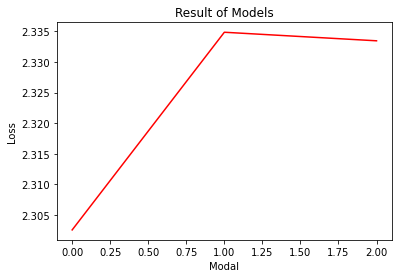

In [117]:
x = range(0,3)
y = loss_list5

plt.plot(x, y,color='r')
plt.xlabel('Modal')
plt.ylabel('Loss')
plt.title('Result of Models')
plt.show()

### Convolutional Layer and Fully Connected Layer Size

| Low FCS && Big CLS | Low FCS && Low CLS  | Big FCS && Low CLS
| --- | --- | --- |
| 14 | 15 | 27 |